### Issues with outliers

In the last subject, we fitted polynomials to different datasets using the polyfit() function, and we saw that it’s minimizing the residual sum of squares (RSS) measure. In this unit, we will see that this process is sensitive to extreme points called outliers due to the nature of the RSS measure. At the end of this unit, you should have the necessary tools to detect and remove outliers using Numpy functions.

This time, we will work with a modified version of the marketing campaign dataset in which we added five outliers.

In [1]:
import pandas as pd

data_df = pd.read_csv("c3_marketing-outliers.csv")
data_df.shape

(55, 4)

The first 50 rows of the DataFrame contain the 50 data points from the marketing-campaign.csv dataset that we saw in the previous units, and we added five rows at the end of the DataFrame. They are outliers in the sense that they are not part of the trend that we can observe in the other data points.

Let’s print these outliers using the Pandas tail() function.

In [2]:
# Last five data points
data_df.tail()

,tv,web,radio,sales
50,2.293,2.314,1.167,8.937
51,2.891,1.895,1.365,8.132
52,1.305,1.940,1.454,8.892
53,11.022,1.855,1.282,1.389
54,11.786,2.066,1.466,1.623


As you can see, rows 50 to 52 have a small television budget but large sales, and rows 53 and 54 have a large television budget but small sales. Since these outliers are at the end of the DataFrame, we can easily separate them from the rest of the points.



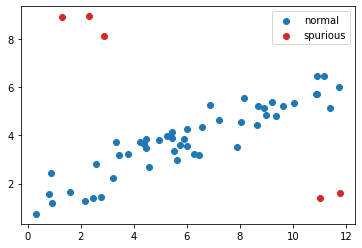

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract tv and sales
x = data_df.tv.values
y = data_df.sales.values

# Plot the data points
plt.scatter(x[:-5], y[:-5], label="normal")
plt.scatter(x[-5:], y[-5:], c="C3", label="spurious")
plt.legend()
plt.show()

In this code, we plot the last 5 data points (the outliers) using plt.scatter(x[-5:], y[-5:]) and the first 50 “normal” points using plt.scatter(x[:-5], y[:-5]).

Note that these outliers are not necessarily incorrect values. The difference could be due to a phenomenon that does not appear in our data, i.e., unobserved variables.

The problem with outliers is that a few of them can have a significant effect on the final model. To illustrate this issue, let’s compare the coefficients of a linear regression on the entire dataset with those from a linear regression fitted without the five outliers.

In [4]:
import numpy as np

# Fit a linear regression
coefs = np.polyfit(x, y, deg=1)
print("coefs:", coefs)

# Fit a linear regression without the 5 outliers
coefs_wo = np.polyfit(x[:-5], y[:-5], deg=1)
print("coefs without outliers:", coefs_wo)

coefs: [0.20613307 2.76540858]
coefs without outliers: [0.42063597 1.27867727]


The two lines a very different. Their slope and intercept terms are different by a factor of two. Since we have just two variables, we can also plot the two models and compare the prediction lines.

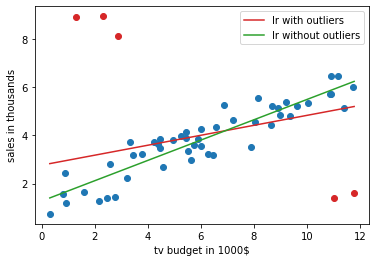

In [5]:
# Compute prediction line
x_values = np.linspace(min(x), max(x), num=100)
y_values = np.polyval(coefs, x_values)
y_values_wo = np.polyval(coefs_wo, x_values)

# Plot them
plt.scatter(x[:-5], y[:-5])
plt.scatter(x[-5:], y[-5:], c="C3")
plt.plot(x_values, y_values, c="C3", label="lr with outliers")
plt.plot(x_values, y_values_wo, c="C2", label="lr without outliers")
plt.xlabel("tv budget in 1000$")
plt.ylabel("sales in thousands")
plt.legend()
plt.show()

In this code, we create a hundred points between min(x) and max(x) with the Numpy linspace() function, and compute the sales estimations using the model coefficients coefs and coefs_wo.

As you can see, the red line doesn’t fit well the trend in the data points in blue. This is because the polyfit() function minimizes the RSS measure which puts too much weight on large errors. 

In [6]:
# Compute predictions for all data points
y_pred = np.polyval(coefs, x)

# Compute the squares of residuals
squares_residuals = np.square(y - y_pred)

print("RSS normal points:", np.sum(squares_residuals[:-5]))
print("RSS outliers:", np.sum(squares_residuals[-5:]))

RSS normal points: 39.533764623373465
RSS outliers: 115.6176164792112


### Remove outliers by hand
In our example, we know that the issue comes from the tv and sales variables, and we can easily separate the outliers from the rest of the data points by defining two regions.

Data points with an x value below 4 and a y value above 6. This corresponds to the upper left corner of the plot.
Data points with an x value above 10 and a y value below 2. This corresponds to the lower right corner.
Here is a plot of the two regions.

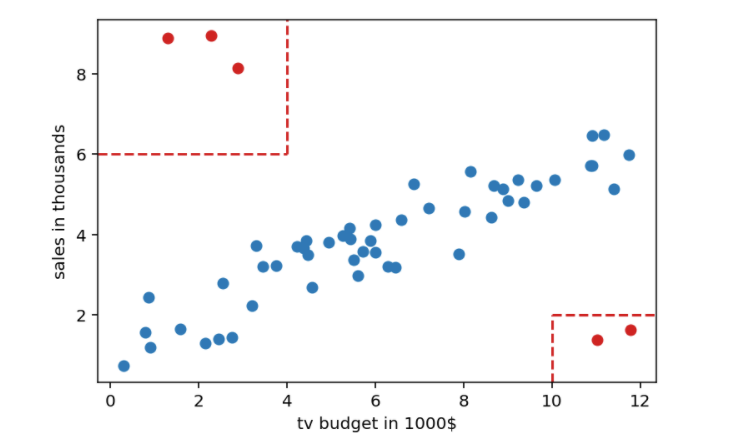

In [8]:
from IPython.display import Image
Image(filename="outliers.png")

The idea is to create an array idx of booleans with True values for data points that are in one of these two regions. To achieve this, we can use the Python bitwise operators & (and) and | (or).

In [9]:
# Points in the upper left or lower right corners
idx = ((x < 4) & (y > 6)) | ((x > 10) & (y < 2))

# Extract "normal" points
x1, y1 = x[~idx], y[~idx]
print("x1/y1:", x1.shape, y1.shape)

# Extract outliers
x2, y2 = x[idx], y[idx]
print("x2/y2:", x2.shape, y2.shape)

x1/y1: (50,) (50,)
x2/y2: (5,) (5,)


In [10]:
# "normal" points
~idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False])

#### Standard scores
Intuitively, an outlier is a value far from the other ones. The standard score formalizes this idea using two statistics: the mean μ and the standard deviation σ. Let’s compute the z-scores for the y values in our marketing campaign dataset.


.

In [11]:
# Compute z-scores
z_scores = (y - y.mean()) / y.std()

print("z-scores:", z_scores.shape)  # (55,)

z-scores: (55,)


In this code, the variable y contains the 55 target values. We compute the mean and the standard deviation using the Numpy mean() and std() functions. Due to broadcasting, Numpy computes the z-score of each element in the y array and returns an array of shape (55,).

We can now visualize these scores using the scatter() function from Pyplot and its c argument.

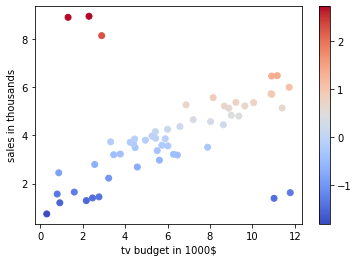

In [12]:
# Plot z-scores
plt.scatter(x, y, c=z_scores, cmap="coolwarm")
plt.xlabel("tv budget in 1000$")
plt.ylabel("sales in thousands")
plt.colorbar()
plt.show()

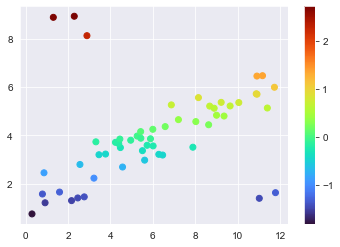

In [13]:
import seaborn as sns

# Activate Seaborn style
sns.set_style("darkgrid")

# Plot z-scores
plt.scatter(x, y, c=z_scores, cmap="turbo")
plt.colorbar()
plt.show()

This time, we only detected the three outliers in the top left corner of the image. Here is the idx mask.

If we remove the outliers using the idx mask and fit a linear regression, we can see that the linear regression is very close to the one obtained by manually removing all the outliers.

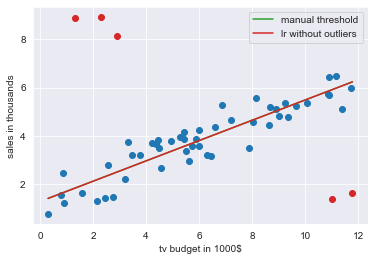

In [14]:
# Fit linear regression
coefs_z = np.polyfit(x[~idx], y[~idx], deg=1)

# Prediction line
y_values_zscore = np.polyval(coefs_z, x_values)

# Final comparison
plt.scatter(x[~idx], y[~idx])
plt.scatter(x[idx], y[idx], c="C3")
plt.plot(x_values, y_values_wo, c="C2", label="manual threshold")
plt.plot(x_values, y_values_zscore, c="C3", label="lr without outliers")
plt.xlabel("tv budget in 1000$")
plt.ylabel("sales in thousands")
plt.legend()
plt.show()

Note that we computed the z-scores on the sales target variable. However, we can apply this process to each variable in our dataset, i.e., including the features.

#### MAE and RSS

##### Summary
Let’s summarize what we’ve learned in this unit. Here are a few takeaways.

When fitting a model, we optimize a cost/loss/objective function
The MAE is robust to outliers which is a nice statistical property but is difficult to optimize because it’s not smooth.
MAE is easy to interpret. For instance, a score of 3 means that the predictions are, in average, above or below the observed value by a distance of 3.
In the next unit, we will learn about the Huber loss which combines the two properties from above. Also, we will see how to fit a model using this cost function with Scikit-learn.

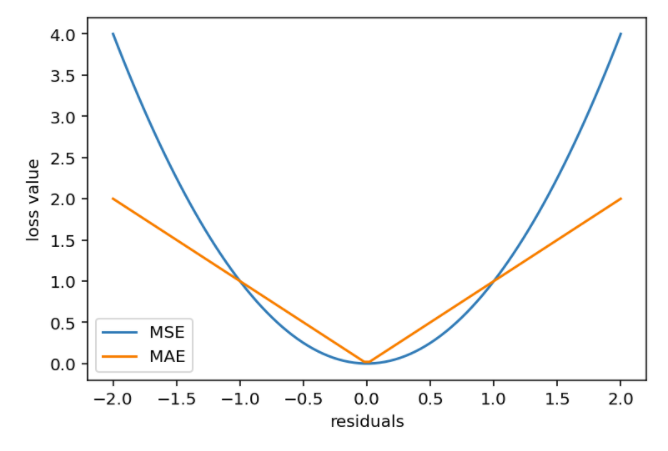

In [2]:
from IPython.display import Image
Image(filename="MSE.png")